# Tutorial I: information theory applied to fMRI

### Dataset: 
- https://github.com/brincolab/High-Order-interactions/tree/master/dataset/timeseries
- functional magnetic resonance imaging (fMRI) data was obtained at rest from 164 healthy subjects with ages ranging from 10 to 80 years 

### Objectives:

Compute high-oder measures (**TC, DTC, O-info, S-info**) to characterize of a fMRI data using a parcellation of 20 brain modules:
- Exhaustively analyzing all the interactions
- Random search
- Greedy search algorithm
- Simulated annealing


---
First, open an Anaconda prompt and create an environment with

conda create -n thoi

Then install the required packages

pip install torch  --index-url https://download.pytorch.org/whl/cpu

pip install thoi

pip install numba

pip install matplotlib

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial
from thoi.collectors import batch_to_csv


from thoi.measures.gaussian_copula import multi_order_measures, nplets_measures
from thoi.heuristics import simulated_annealing, greedy
from thoi.heuristics.simulated_annealing import random_sampler


In [5]:
# Functions.
# list of ids to binary matrix
def ids2binary(ids, N):
    num_rows = len(ids)
    binary_matrix = np.zeros((num_rows, N), dtype=bool)
    rows = np.arange(num_rows)[:, None]
    binary_matrix[rows, ids] = True

    return binary_matrix

# defining function for extracting maximum and minimum per order and global

def get_max_min_meas(ints_k, ints_measures_k):
    norders = len(ints_k)
    nmeas = 4
    
    # Search maximum and minimum
    max_id = [np.argmax(x, axis=0) for x in ints_measures_k]
    min_id = [np.argmin(x, axis=0) for x in ints_measures_k]
    
    # Initialize arrays for extracting associated values for each measure
    max_vals_k = np.zeros((norders, nmeas))
    min_vals_k = np.zeros((norders, nmeas))
    max_ints_k = [[]]*nmeas
    min_ints_k = [[]]*nmeas
    
    # Use vectorized operations to fill max_vals_k and min_vals_k
    for m_id in range(nmeas):
        # Extract interactions
        max_ints_k[m_id] = [np.where(x[y][m_id])[0] for x, y in zip(ints_k, max_id)]
        min_ints_k[m_id] = [np.where(x[y][m_id])[0] for x, y in zip(ints_k, min_id)]
        # Extracting values
        max_vals_k[:, m_id] = [x[max_id[idx][m_id], m_id] for idx, x in enumerate(ints_measures_k)]
        min_vals_k[:, m_id] = [x[min_id[idx][m_id], m_id] for idx, x in enumerate(ints_measures_k)]
    
    # Extract maximum and minimum values across orders
    glob_max_ids = np.argmax(max_vals_k, axis=0)
    glob_min_ids = np.argmin(min_vals_k, axis=0)
    
    max_vals = max_vals_k[glob_max_ids, np.arange(nmeas)]
    min_vals = min_vals_k[glob_min_ids, np.arange(nmeas)]
    
    # Extract corresponding interactions
    max_ints = [max_ints_k[m_id][glob_max_ids[m_id]] for m_id in range(nmeas)]
    min_ints = [min_ints_k[m_id][glob_min_ids[m_id]] for m_id in range(nmeas)]
        
    return max_ints, min_ints, max_vals, min_vals, max_vals_k, min_vals_k, max_ints_k, min_ints_k


In [8]:
#basefold = "/home/ruben.herzog/OneDrive/Projects/THOI/TutorialFrankfurt/dataset/timeseries/"
# basefold = "C:\\Users\\rherz\\OneDrive\\Documents\\Projects\\Frankfurt2024\\Tutorials\\dataset\\timeseries\\"
basefold = "C:\\Users\\rherz\\OneDrive\\Documents\\Projects\\Frankfurt2024\\Tutorials\\dataset\\timeseries\\"

# basefold = '/home/laouen.belloli/Documents/git/High-Order-interactions/dataset/timeseries/'
modules = 20 # number of modules
min_int = 3
norders = modules - min_int +1
nsubj = 161 #number of participants
timepoints = 159 #number of time points

data =  np.zeros((nsubj,modules,timepoints))

for participant in range(nsubj):
    ts = np.loadtxt(basefold+"ts_m20_p%.3i.txt"%(participant+1))
    data[participant,:,:] = ts[:,:159]#We recommend truncating all the data to the same number of samples. In this example 159.


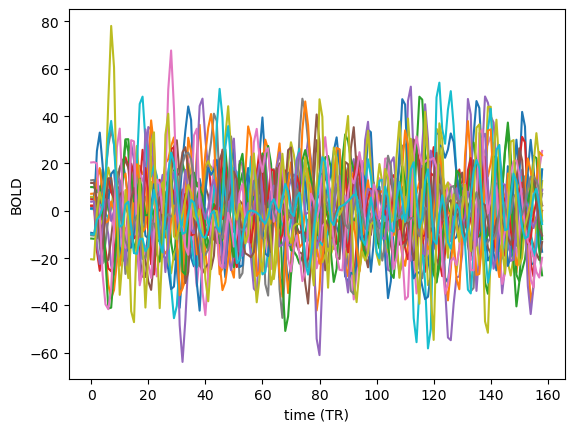

In [5]:
# Checking that loading works. Plotting one subjec
plt.figure()
plt.plot(data[10,:,:].T)#Plotting the BOLD for one subject
plt.xlabel("time (TR)")
plt.ylabel("BOLD")
plt.show()

### Computing high-order metrics for all subjects concatenated

In [9]:
# Concatenating all subjects
X = np.transpose(data, axes=(1, 0, 2)).reshape(20, -1).T
results = multi_order_measures(X, use_cpu=True, batch_aggregation=list) # returns a list with dataframe where each entry is a order
# results = multi_order_measures(X, use_cpu=True) # returns a dataframe with all order concatenated
# took ~150 seconds

Order:   0%|          | 0/18 [00:00<?, ?it/s]

Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Batch:   0%|          | 0/1 [00:00<?, ?it/s]

### Exaustive: Extracting maximum and minimum per order and across orders

In [10]:
meas_name = results[0].columns[0:4]
nmeas = len(meas_name)
ints_measures_k = [[]]*norders
ints_k = [x.iloc[:,nmeas:].to_numpy() for x in results]
ints_measures_k = [x[meas_name].to_numpy() for x in results]
# Extracting maximum and minimum per order and across orders
max_ints, min_ints, max_vals, min_vals, max_vals_k, min_vals_k, max_ints_k, min_ints_k = get_max_min_meas(ints_k,ints_measures_k)
[max_ints, max_vals, min_ints, min_vals ]
# 

[[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19], dtype=int64),
  array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19], dtype=int64),
  array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19], dtype=int64),
  array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19], dtype=int64)],
 array([4.31973918, 3.49950891, 0.82023027, 7.8192481 ]),
 [array([ 7, 13, 17], dtype=int64),
  array([ 7, 13, 17], dtype=int64),
  array([ 0,  2,  3,  8, 14, 15, 16, 17], dtype=int64),
  array([ 7, 13, 17], dtype=int64)],
 array([ 0.00046841,  0.00046337, -0.22157918,  0.00093178])]

# Using optimization algorithms for finding the maximum or minimum for each measure


## 1. Random search

---
Here we sample 'nrand' random sets of $k$ variables and compute their respective measures. Then, we compute the maximum and minimim measure for each order of interaction.

In [11]:
nrand = 100 # play with this to have a notion of the random sample size to get the true values # 100000 in 130 min
# Generating random indices of interactions for each order
random_ints = [random_sampler(modules, order=x, repeat=nrand) for x in range(3,modules)]
random_ints_binmat = [ids2binary(x, modules) for x in random_ints]
# Computing
random_ints_measures = [np.vstack(nplets_measures(X,ints)) for ints in random_ints]
# Extracting maxmimum and minimum
rnd_max_ints, rnd_min_ints, rnd_max_vals, rnd_min_vals, rnd_max_vals_k, rnd_min_vals_k, _, _ = get_max_min_meas(random_ints_binmat,random_ints_measures)
for m_id, meas in enumerate(meas_name):
    print('------')    
    print(f'{meas.upper()}')
    print(f'Estimated max: {rnd_max_vals[m_id]}. Real {meas.upper()}: {max_vals[m_id]}') 
    print(f'Error max: {rnd_max_vals[m_id] - max_vals[m_id]}\n')     
    print(f'Estimated min: {rnd_min_vals[m_id]}. Real {meas.upper()}: {min_vals[m_id]}') 
    print(f'Error min: {rnd_min_vals[m_id] - min_vals[m_id]}') 
    


------
TC
Estimated max: 4.125960669621151. Real TC: 4.319739183273555
Error max: -0.19377851365240417

Estimated min: 0.0015176429790599855. Real TC: 0.00046841424350319016
Error min: 0.0010492287355567953
------
DTC
Estimated max: 3.356246134247556. Real DTC: 3.4995089149813907
Error max: -0.14326278073383492

Estimated min: 0.0015036205473464292. Real DTC: 0.00046336957840154014
Error min: 0.0010402509689448891
------
O
Estimated max: 0.8102082199386302. Real O: 0.820230268292164
Error max: -0.010022048353533819

Estimated min: -0.12080738266632274. Real O: -0.22157918145105704
Error min: 0.1007717987847343
------
S
Estimated max: 7.443623046338011. Real S: 7.8192480982549455
Error max: -0.3756250519169342

Estimated min: 0.0030212635264064147. Real S: 0.0009317838219047303
Error min: 0.0020894797045016844


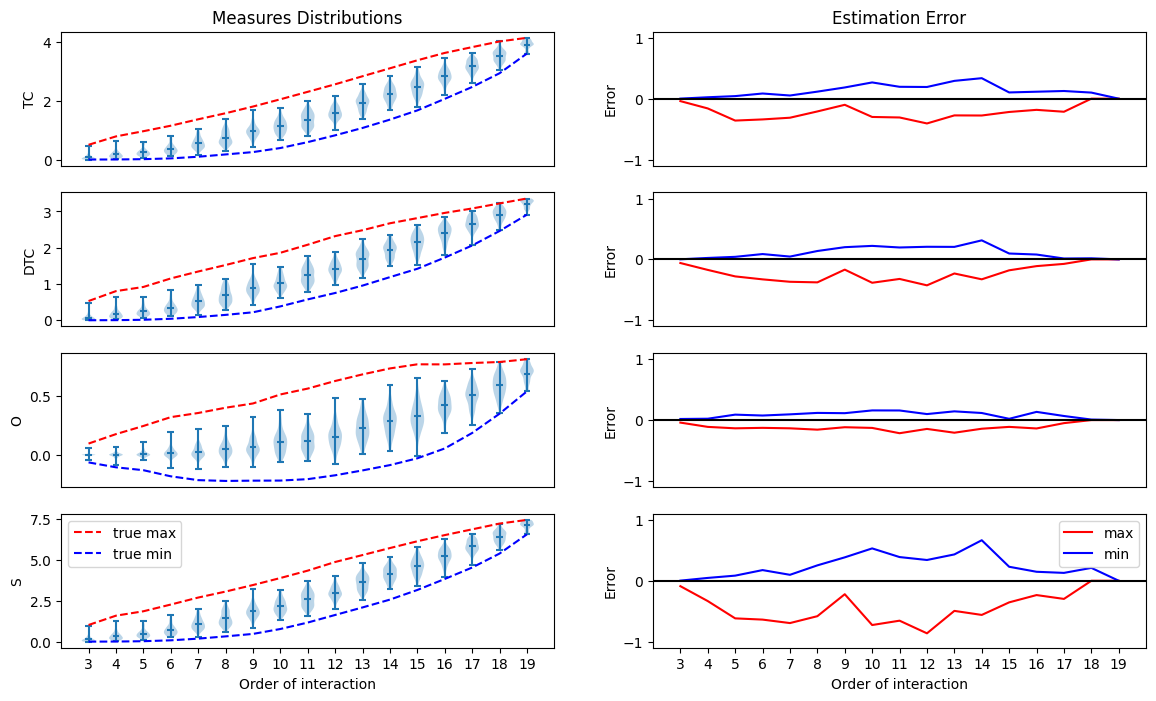

In [12]:
## Plotting across orders
cat_random_ints_measures = np.stack(random_ints_measures)
xx = np.arange(3,modules)

plt.figure(figsize=(14,8))
cont = 0
for m_id, meas in enumerate(meas_name):
    # Plotting violinplots
    plt.subplot(4,2,(m_id)*2+1)

    plt.violinplot(cat_random_ints_measures[:,:,m_id].T, 
                   positions=xx, showmeans=True)
    plt.plot(xx,max_vals_k[:-1,m_id], color='r', linestyle='--', label='true max') 
    plt.plot(xx,min_vals_k[:-1,m_id], color='b', linestyle='--', label='true min') 
    plt.xlim([2,modules])
    if m_id==0:
        plt.title('Measures Distributions')
    
    plt.ylabel(meas.upper())
    if m_id<nmeas-1:
        plt.xticks([])
    else:
        plt.xticks(xx)
        plt.xlabel('Order of interaction')
        plt.legend()
    # Plotting error per orde
    plt.subplot(4,2,(m_id)*2+2)
    plt.plot(xx,rnd_max_vals_k[:,m_id]-max_vals_k[:-1,m_id], 'r', label='max')
    plt.plot(xx,rnd_min_vals_k[:,m_id]-min_vals_k[:-1,m_id],'b', label='min')
    plt.axhline(y=0,color='k')
    plt.ylabel('Error')
    plt.xlim([2,modules])
    plt.ylim([-1.1,1.1])
    if m_id ==0:
        plt.title('Estimation Error')
        
    if m_id<nmeas-1:
        plt.xticks([])
    else:
        plt.xticks(xx)
        plt.xlabel('Order of interaction')
        plt.legend()
    
    cont=+1
    
    

plt.show()




## 2. Greedy search
---

Let's illustrate a greedy optimization procedure where the free parameters are the identities of $k$ variables from a set of $ N $ variables. The procedure involves iteratively adding one variable to the current set of selected variables, evaluating the objective function, and keeping the variable that maximizes the objective function until the optimal set of $ k $ variables is found.

### Explanation

#### Initialization:

- Start with a random set of # k # variables, say ${x_1, x_2, x_3}$.
- Compute the objective function $f(x_1, x_2, x_3)$.

#### Iterative Improvement:

- For each iteration, add one more variable from the remaining $N - k$ variables to the current set.
- Evaluate the objective function for each candidate set of $k + 1$ variables.
- Select the variable that, when added, results in the maximum objective function value.

We repeat this process until a maximal number of variables $max_k$ defined by the user. 

If we want to use for minimization, we use the negative of the objective function

In [13]:
# Running Greedy
max_k = modules-1
min_k = 3
repeat = 5 # platy with this number to obtain true solution. 1000 is almost perfect. 10000 ~60 takes seconds
# Maximizing
greedy_out = [greedy(X, max_k , min_k, repeat=repeat, metric=meas, largest=True) for meas in meas_name]
g_max_partitions = [x[0] for x in greedy_out]
g_max_scores = [np.vstack(x[1]) for x in greedy_out]
g_max_vals = [np.max(x,axis=0) for x in g_max_scores]

# Minimizing
greedy_out = [greedy(X, max_k , min_k, repeat=repeat, metric=meas, largest=False) for meas in meas_name]
g_min_partitions = [x[0] for x in greedy_out]
g_min_scores = [np.vstack(x[1]) for x in greedy_out]
g_min_vals = [np.min(x,axis=0) for x in g_min_scores]

Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Candidates:   0%|                                                                               | 0/16 [00:00<?, ?it/s]
                                                                                                                       
Candidates:   0%|                                                                               | 0/15 [00:00<?, ?it/s]
                                                                                                                       
Candidates:   0%|                                                                               | 0/13 [00:00<?, ?it/s]
                                                                                                                       
Candidates:   0%|                                                                               | 0/12 [00:00<?, ?it/s]
                                                                                                                       
Candidates:   0%|                       

Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Candidates:   0%|                                                                               | 0/16 [00:00<?, ?it/s]
                                                                                                                       
Candidates:   0%|                                                                               | 0/15 [00:00<?, ?it/s]
                                                                                                                       
Candidates:   0%|                                                                               | 0/14 [00:00<?, ?it/s]
                                                                                                                       
Candidates:   0%|                                                                               | 0/12 [00:00<?, ?it/s]
                                                                                                                       
Candidates:   0%|                       

Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Candidates:   0%|                                                                               | 0/16 [00:00<?, ?it/s]
                                                                                                                       
Candidates:   0%|                                                                               | 0/15 [00:00<?, ?it/s]
                                                                                                                       
Candidates:   0%|                                                                               | 0/14 [00:00<?, ?it/s]
                                                                                                                       
Candidates:   0%|                                                                               | 0/12 [00:00<?, ?it/s]
                                                                                                                       
Candidates:   0%|                       

Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Candidates:   0%|                                                                               | 0/16 [00:00<?, ?it/s]
                                                                                                                       
Candidates:   0%|                                                                               | 0/15 [00:00<?, ?it/s]
                                                                                                                       
Candidates:   0%|                                                                               | 0/14 [00:00<?, ?it/s]
                                                                                                                       
Candidates:   0%|                                                                               | 0/12 [00:00<?, ?it/s]
                                                                                                                       
Candidates:   0%|                       

Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Candidates:   0%|                                                                               | 0/16 [00:00<?, ?it/s]
                                                                                                                       
Candidates:   0%|                                                                               | 0/15 [00:00<?, ?it/s]
                                                                                                                       
Candidates:   0%|                                                                               | 0/14 [00:00<?, ?it/s]
                                                                                                                       
Candidates:   0%|                                                                               | 0/12 [00:00<?, ?it/s]
                                                                                                                       
Candidates:   0%|                       

Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Candidates:   0%|                                                                               | 0/16 [00:00<?, ?it/s]
                                                                                                                       
Candidates:   0%|                                                                               | 0/15 [00:00<?, ?it/s]
                                                                                                                       
Candidates:   0%|                                                                               | 0/13 [00:00<?, ?it/s]
                                                                                                                       
Candidates:   0%|                                                                               | 0/12 [00:00<?, ?it/s]
                                                                                                                       
Candidates:   0%|                       

Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Candidates:   0%|                                                                               | 0/16 [00:00<?, ?it/s]
                                                                                                                       
Candidates:   0%|                                                                               | 0/15 [00:00<?, ?it/s]
                                                                                                                       
Candidates:   0%|                                                                               | 0/14 [00:00<?, ?it/s]
                                                                                                                       
Candidates:   0%|                                                                               | 0/12 [00:00<?, ?it/s]
                                                                                                                       
Candidates:   0%|                       

Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Candidates:   0%|                                                                               | 0/16 [00:00<?, ?it/s]
                                                                                                                       
Candidates:   0%|                                                                               | 0/15 [00:00<?, ?it/s]
                                                                                                                       
Candidates:   0%|                                                                               | 0/14 [00:00<?, ?it/s]
                                                                                                                       
Candidates:   0%|                                                                               | 0/12 [00:00<?, ?it/s]
                                                                                                                       
Candidates:   0%|                       

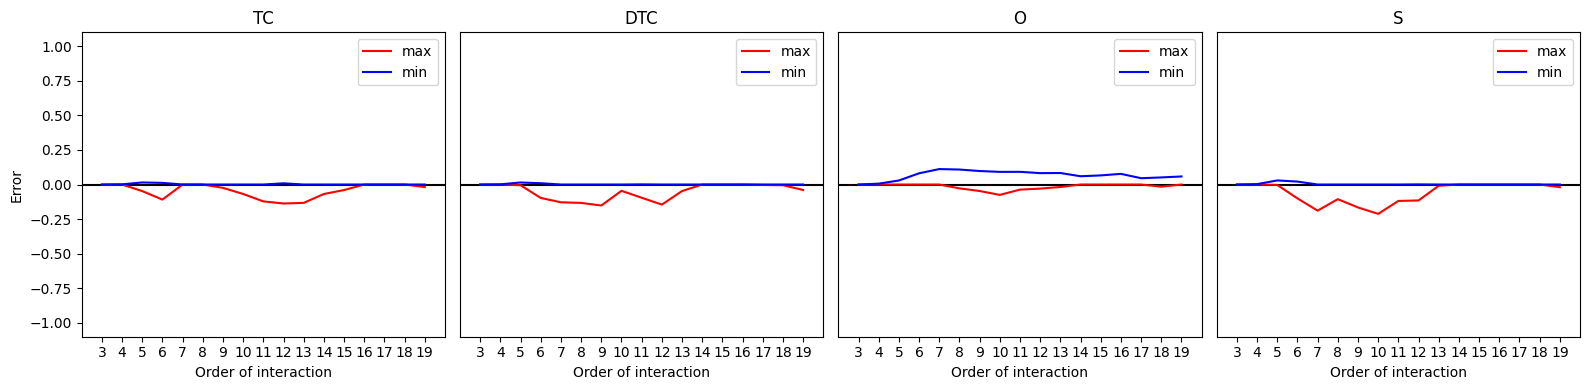

In [14]:
plt.figure(figsize=(16,4))
for m_id, meas in enumerate(meas_name):
    # Plotting error per orde
    plt.subplot(1,4,m_id+1)
    plt.axhline(y=0,color='k')    
    plt.plot(xx,g_max_vals[m_id]-max_vals_k[:-1,m_id], 'r', label='max')
    plt.plot(xx,g_min_vals[m_id]-min_vals_k[:-1,m_id],'b', label='min')
    plt.xlim([2,modules])
    plt.ylim([-1.1,1.1])
    plt.title(meas.upper())
    plt.legend()
    plt.xticks(xx)
    plt.xlabel('Order of interaction')
    if m_id==0:
        plt.ylabel('Error')
    else:
        plt.yticks([])
    
# 
plt.tight_layout()
plt.show()

## 3. Simulated annealing

---

Let's illustrate a simulated annealing optimization procedure where the free parameters are the identities of $ k $ variables from a set of $ N $ variables. The procedure involves iteratively adding one variable to the current set of selected variables, evaluating the objective function, and making probabilistic decisions to accept new solutions based on a temperature $ T $ that decreases over time with a cooling rate $ c\_rate $.

### Explanation

#### Initialization:

- Start with a random set of $ k $ variables, say $\{x_1, x_2, x_3\}$.
- Compute the objective function $ f(x_1, x_2, x_3) $.
- Initialize the temperature $ T $.

#### Iterative Improvement:

- For each iteration:
  - Add one more variable from the remaining $ N - k $ variables to the current set.
  - Evaluate the objective function for each candidate set of $ k + 1 $ variables.
  - Calculate the change in the objective function $ \Delta f $.
  - If $ \Delta f $ is positive, accept the new set of variables.
  - If $ \Delta f $ is negative, accept the new set of variables with a probability $ e^{\Delta f / T} $.
  - Reduce the temperature $ T $ according to the cooling rate $ c\_rate $: $ T = T \times c\_rate $.


We stop the optimization if no new solution is found after 'early stop' iterations


In [15]:
# Running Simulated annealing
# Optimization per order

repeat = 2 # play with this parameter. 10 took ~160 seconds
sa_max_vals_k = np.zeros((nmeas,norders))
sa_min_vals_k = np.zeros((nmeas,norders))

for k in range(3,modules):
    print('Order:',k)
    # Maximizing
    print('Maximizing')
    sa_out = [simulated_annealing(X, order=k, repeat=repeat, metric=meas, largest=True) for meas in meas_name]
    sa_max_partitions = [x[0] for x in sa_out]
    sa_max_scores = [np.vstack(x[1]) for x in sa_out]
    sa_max_vals_k[:,k-3] = np.squeeze(np.max(sa_max_scores,axis=1))
    
    # Minimizing
    print('Minimizing')
    sa_out = [simulated_annealing(X, order=k, repeat=repeat, metric=meas, largest=False) for meas in meas_name]
    sa_min_partitions = [x[0] for x in sa_out]
    sa_min_scores = [np.hstack(x[1]) for x in sa_out]
    sa_min_vals_k[:,k-3] = np.squeeze(np.min(sa_min_scores,axis=1))

Order: 3
Maximizing


Early stop reached


Early stop reached


Early stop reached


Early stop reached
Minimizing


Early stop reached


Early stop reached


Early stop reached


Early stop reached
Order: 4
Maximizing


Early stop reached


Early stop reached


Early stop reached


Early stop reached
Minimizing


Early stop reached


Early stop reached


Early stop reached


Early stop reached
Order: 5
Maximizing


Early stop reached


Early stop reached


Early stop reached


Early stop reached
Minimizing


Early stop reached


Early stop reached


Early stop reached


Early stop reached
Order: 6
Maximizing


Early stop reached


Early stop reached


Early stop reached


Early stop reached
Minimizing


Early stop reached


Early stop reached


Early stop reached


Early stop reached
Order: 7
Maximizing


Early stop reached


Early stop reached


Early stop reached


Early stop reached
Minimizing


Early stop reached


Early stop reached


Early stop reached


Early stop reached
Order: 8
Maximizing


Early stop reached


Early stop reached


Early stop reached


Early stop reached
Minimizing


Early stop reached


Early stop reached


Early stop reached


Early stop reached
Order: 9
Maximizing


Early stop reached


Early stop reached


Early stop reached


Early stop reached
Minimizing


Early stop reached


Early stop reached


Early stop reached


Early stop reached
Order: 10
Maximizing


Early stop reached


Early stop reached


Early stop reached


Early stop reached
Minimizing


Early stop reached


Early stop reached


Early stop reached


Early stop reached
Order: 11
Maximizing


Early stop reached


Early stop reached


Early stop reached


Early stop reached
Minimizing


Early stop reached


Early stop reached


Early stop reached


Early stop reached
Order: 12
Maximizing


Early stop reached


Early stop reached


Early stop reached


Early stop reached
Minimizing


Early stop reached


Early stop reached


Early stop reached


Early stop reached
Order: 13
Maximizing


Early stop reached


Early stop reached


Early stop reached


Early stop reached
Minimizing


Early stop reached


Early stop reached


Early stop reached


Early stop reached
Order: 14
Maximizing


Early stop reached


Early stop reached


Early stop reached


Early stop reached
Minimizing


Early stop reached


Early stop reached


Early stop reached


Early stop reached
Order: 15
Maximizing


Early stop reached


Early stop reached


Early stop reached


Early stop reached
Minimizing


Early stop reached


Early stop reached


Early stop reached


Early stop reached
Order: 16
Maximizing


Early stop reached


Early stop reached


Early stop reached


Early stop reached
Minimizing


Early stop reached


Early stop reached


Early stop reached


Early stop reached
Order: 17
Maximizing


Early stop reached


Early stop reached


Early stop reached


Early stop reached
Minimizing


Early stop reached


Early stop reached


Early stop reached


Early stop reached
Order: 18
Maximizing


Early stop reached


Early stop reached


Early stop reached


Early stop reached
Minimizing


Early stop reached


Early stop reached


Early stop reached


Early stop reached
Order: 19
Maximizing


Early stop reached


Early stop reached


Early stop reached


Early stop reached
Minimizing


Early stop reached


Early stop reached


Early stop reached


Early stop reached


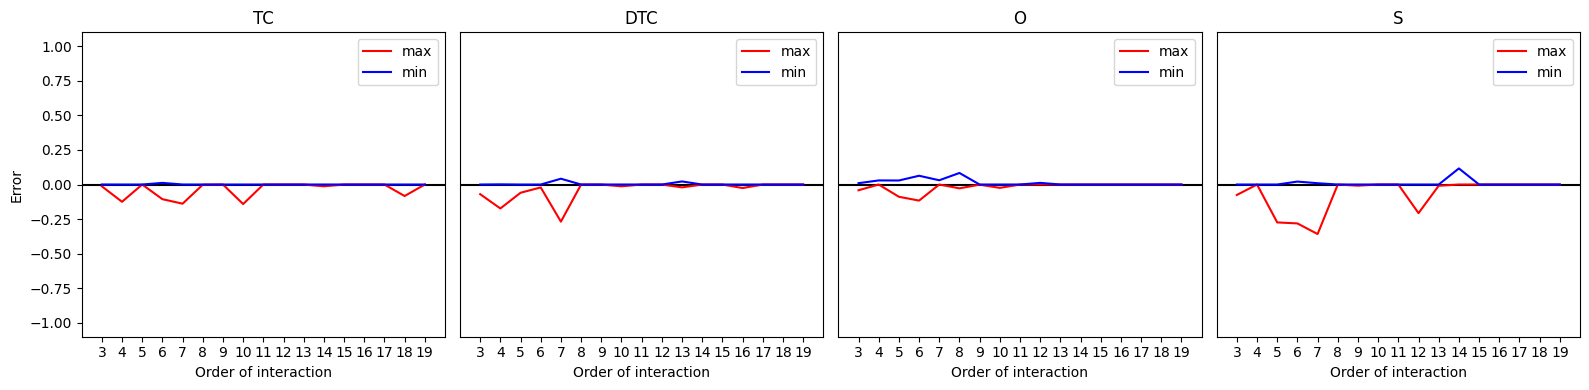

In [16]:
# Plotting
plt.figure(figsize=(16,4))
for m_id, meas in enumerate(meas_name):
    # Plotting error per orde
    plt.subplot(1,4,m_id+1)
    plt.axhline(y=0,color='k')    
    plt.plot(xx,sa_max_vals_k[m_id,:-1]-max_vals_k[:-1,m_id], 'r', label='max')
    plt.plot(xx,sa_min_vals_k[m_id,:-1]-min_vals_k[:-1,m_id], 'b', label='min')
    plt.xlim([2,modules])
    plt.ylim([-1.1,1.1])
    plt.title(meas.upper())
    plt.legend()
    plt.xticks(xx)
    plt.xlabel('Order of interaction')
    if m_id==0:
        plt.ylabel('Error')
    else:
        plt.yticks([])
    

plt.tight_layout()
plt.show()

### Bonus track: exaustive approach for all subjects in less than one hour
Uses paralellization and writes the output into disk to avoid RAM issues.

To read the data of each subject, load all the data of each subject from disk

In [18]:
from joblib import Parallel, delayed
outputfolder = "C:\\Users\\rherz\\OneDrive\\Documents\\Projects\\Frankfurt2024\\Tutorials\\hois_output\\"
# The parallelized processing
def process_subject(sel_sub):
        X = data[sel_sub,:,:].T
        # Creating output
        save_func = partial(        
        batch_to_csv,
        N=20,
        output_path=outputfolder+'sub-'+str(sel_sub)+'_k-{order}_batch-{bn}.tsv'
        )
        multi_order_measures(X, use_cpu=True, batch_size=10000,
                             batch_data_collector=save_func, 
                             batch_aggregation=lambda x: x)
        return None

# Number of CPUs to use
num_cpus = 4  # Set to the number of CPUs you want to use

# Use joblib to parallelize
results_list = Parallel(n_jobs=num_cpus)(delayed(process_subject)(i) for i in range(num_cpus))
